# Concept
The data used here shows various outcomes from firms' financial statements combined with information about data breaches that happen to the firms. I will split the data for firms at some relative point in time (eg 75% of the way through the data for each firm). Then I will use the first section of the data as a training set, and the second section of the data as a test set to see how well the models perform.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import neural_network
from sklearn import pipeline
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor 
warnings.filterwarnings('ignore')

In [2]:
comp = pd.read_csv('data/COMPUSTAT_vars.csv')
comp['datadate'] = pd.to_datetime(comp['datadate'])
comp['breachdate'] = pd.to_datetime(comp['Date.Made.Public'])

This shows the number of firms we have data for

In [4]:
len(comp['GVKEY'].unique())

414

Create a time variable that is between 0 and 1 for every firm. Split this by time period by some arbitrary amount, then use the first part as training, and the second part as validation/testing. Also convert the time of the data breach into this scaled time, since this is useful information, and all non numeric data gets thrown out.

In [5]:
def make_scaled_time(sl):
    start_date = sl['datadate'].min()
    end_date = sl['datadate'].max()
    length = end_date - start_date
    scaled_time = (sl['datadate'] - start_date)/length
    breachdate_scaled = (sl['breachdate'] - start_date)/length
    
    return pd.concat([scaled_time, breachdate_scaled, sl['datadate'], sl['GVKEY']], axis=1)

In [6]:
comp = comp.reset_index()
scaled_time = comp.groupby(by='GVKEY').apply(make_scaled_time)
scaled_time.columns = ['scaled_time', 'breachdate_scaled', 'datadate', 'GVKEY']
comp = pd.merge(comp, scaled_time, how='left', on=['datadate', 'GVKEY'])

# 5 companies have only one observation and therefore scaled_time is nan
# Just going to remove these because they aren't interesting anyway
comp = comp[comp['scaled_time'].notnull()]
comp = comp[comp['breachdate_scaled'].notnull()]
comp['scaled_time'] = comp['scaled_time'].astype(float)
comp['breachdate_scaled'] = comp['breachdate_scaled'].astype(float)

# Get rid of any useless columns
try:
    del comp['Unnamed: 0']
    del comp['index']
except KeyError:
    pass

Functions to build and test the ML models

In [7]:
# Fit models and return cv mse
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test, cv=5):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test)),
        mse_cv = -np.mean(cross_val_score(mod, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')),
        model = mod
    )

# Pipeline with input scaling
def make_nn_model(params, activation='logistic', solver='adam', alpha=0.0, learning_rate='constant'):
    nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor(params,
                                activation=activation,
                                solver=solver,
                                alpha=alpha,
                                learning_rate=learning_rate)
    )
    return nn_scaled_model

Now we are ready to create the training and test sets. Because I have a lot of input data I create effectively two data sets with different input variables. The "firm" data includes all the variables in the data which are firm specific, for example, quarterly revenue. With this as the input it should be very easy to predict the outcome (profit), but not particularly useful, as we are unlikely to know everything about a firm other than profit. In other words this is basically a warm-up to make sure the models work when they have a large amount of information availible to them. The "(ext)ernal" data includes all data that is external to the firm, for example, GDP. These consist mainly of macroeconomic controls that I collected for my thesis. These contain much less information, so I expect the models to not fit as well, but it is much more useful, because if these models are good it could allow us to predict a firm's profit in the future without knowing anything about the firm itself in the future. For both I also include information about data breaches since the data breaches will happen in the data, and information about them should provide some useful information to the models.

In [8]:
breach_data = comp.columns[397:405].tolist() + comp.columns[410:418].tolist() + ['scaled_time']
firm_data = comp.columns[0:386].tolist() + ['scaled_time']
ext_data = comp.columns[419:442].tolist() + ['GVKEY', 'scaled_time'] 

In [9]:
# Use 75% of data for training
training_cutoff = 0.75
outcomes = ['niq'] # Profit will be the oucome
excluded = ['fyr', 'datadate', 'indfmt', 'consol', 'popsrc', 'datafmt',
            'cusip', 'curcdq', 'curncdq', 'currtrq', 'datacqtr', 'datafqtr',
            'Date.Made.Public', 'fic', 'Type.of.organization', 'Type.of.breach', 
            'costat', 'tic']

inputs_firm = [x for x in set(breach_data).union(set(firm_data)) if x not in outcomes and x not in excluded]
inputs_ext = [x for x in set(breach_data).union(set(ext_data)) if x not in outcomes and x not in excluded]

# Remove non-numeric data, none of these are actually useful anyway
comp = comp.select_dtypes(include=['float64', 'int64'])
# Deal with NAs
try:
    comp = comp.interpolate(method='nearest')
except ValueError:
    # entire column is empty -> ignore and fill with zeros
    pass
comp = comp.fillna(0)

X_firm_train = comp[comp['scaled_time'] < training_cutoff][inputs_firm]
X_firm_test = comp[comp['scaled_time'] >= training_cutoff][inputs_firm]
X_ext_train = comp[comp['scaled_time'] < training_cutoff][inputs_ext]
X_ext_test = comp[comp['scaled_time'] >= training_cutoff][inputs_ext]

y_train = comp[comp['scaled_time'] <  training_cutoff][outcomes[0]]
y_test = comp[comp['scaled_time'] >= training_cutoff][outcomes[0]]

comp_train = comp[comp['scaled_time'] < training_cutoff]
comp_test = comp[comp['scaled_time'] >= training_cutoff]

Finally, we will begin training the models. First the neural net, and then random forest, using first the firm specific data, and then the external data. For the neural networks I use a small grid search over two possible network shapes and some values for the l1 normalization parameter in order to get a better estimate of the optimal model. The final model I choose is the one with the lowest cross validation MSE. For the random forests the cv mse will be more or less monotonically decreasing in the number of trees, so it is sufficient to estimate one model with a large number of trees.

In [10]:
params = [[100], [50, 25]]
alphas = [10 ** -i for i in range(1, 6)]
firm_training_results = []
models = []
for param in params:
    for alpha in alphas:
        models.append({
            'param': param,
            'alpha': alpha,
            'model': make_nn_model(param, alpha=alpha, learning_rate='constant')
        })
                
for d in models:
    print('Training network with shape params {} and alpha {}'.format(d['param'], d['alpha']))
    trained = fit_and_report_mses(d['model'], X_firm_train, X_firm_test, y_train, y_test)
    trained['params'] = d['param']
    trained['alpha'] = d['alpha']
    firm_training_results.append(trained)
    
firm_mse_nn = pd.DataFrame(firm_training_results)

Training network with shape params [100] and alpha 0.1
Training network with shape params [100] and alpha 0.01
Training network with shape params [100] and alpha 0.001
Training network with shape params [100] and alpha 0.0001
Training network with shape params [100] and alpha 1e-05
Training network with shape params [50, 25] and alpha 0.1
Training network with shape params [50, 25] and alpha 0.01
Training network with shape params [50, 25] and alpha 0.001
Training network with shape params [50, 25] and alpha 0.0001
Training network with shape params [50, 25] and alpha 1e-05


In [11]:
optimal_firm_nn = firm_mse_nn.iloc[firm_mse_nn['mse_cv'].idxmin()]
print('Optimal neural network parameters {} with alpha {}'.format(optimal_firm_nn['params'], optimal_firm_nn['alpha']))
optimal_firm_nn_model = optimal_firm_nn['model']
comp_train['firm_nn_predicted_niq'] = optimal_firm_nn_model.predict(X_firm_train)
comp_test['firm_nn_predicted_niq'] = optimal_firm_nn_model.predict(X_firm_test)

Optimal neural network parameters [100] with alpha 1e-05


In [12]:
print('Training Random Forest with {} trees on firm specific data'.format(50))
firm_rf = fit_and_report_mses(RandomForestRegressor(n_estimators=50), X_firm_train, X_firm_test, y_train, y_test)
firm_rf_model = firm_rf['model']
comp_train['firm_rf_predicted_niq'] = firm_rf_model.predict(X_firm_train)
comp_test['firm_rf_predicted_niq'] = firm_rf_model.predict(X_firm_test)

Training Random Forest with 50 trees on firm specific data


In [13]:
ext_training_results = []

for d in models:
    print('Training network with shape params {} and alpha {}'.format(d['param'], d['alpha']))
    trained = fit_and_report_mses(d['model'], X_ext_train, X_ext_test, y_train, y_test)
    trained['params'] = d['param']
    trained['alpha'] = d['alpha']
    ext_training_results.append(trained)
    
ext_mse_nn = pd.DataFrame(ext_training_results)

Training network with shape params [100] and alpha 0.1
Training network with shape params [100] and alpha 0.01
Training network with shape params [100] and alpha 0.001
Training network with shape params [100] and alpha 0.0001
Training network with shape params [100] and alpha 1e-05
Training network with shape params [50, 25] and alpha 0.1
Training network with shape params [50, 25] and alpha 0.01
Training network with shape params [50, 25] and alpha 0.001
Training network with shape params [50, 25] and alpha 0.0001
Training network with shape params [50, 25] and alpha 1e-05


In [14]:
optimal_ext_nn = ext_mse_nn.iloc[ext_mse_nn['mse_cv'].idxmin()]
print('Optimal neural network parameters {} with alpha {}'.format(optimal_ext_nn['params'], optimal_ext_nn['alpha']))
optimal_ext_nn_model = optimal_ext_nn['model']
comp_train['ext_nn_predicted_niq'] = optimal_ext_nn_model.predict(X_ext_train)
comp_test['ext_nn_predicted_niq'] = optimal_ext_nn_model.predict(X_ext_test)

Optimal neural network parameters [100] with alpha 0.1


In [15]:
print('Training Random Forest with {} trees on external data'.format(50))
ext_rf = fit_and_report_mses(RandomForestRegressor(n_estimators=50), X_ext_train, X_ext_test, y_train, y_test)
ext_rf_model = ext_rf['model']
comp_train['ext_rf_predicted_niq'] = ext_rf_model.predict(X_ext_train)
comp_test['ext_rf_predicted_niq'] = ext_rf_model.predict(X_ext_test)

Training Random Forest with 50 trees on external data


Now that we have trained the 4 models we can plot actual and predicted profit against scaled time in order to visualize how well the models are performing. This code shows plots for each model for a randomly selected firm that changes each time it is re-run.

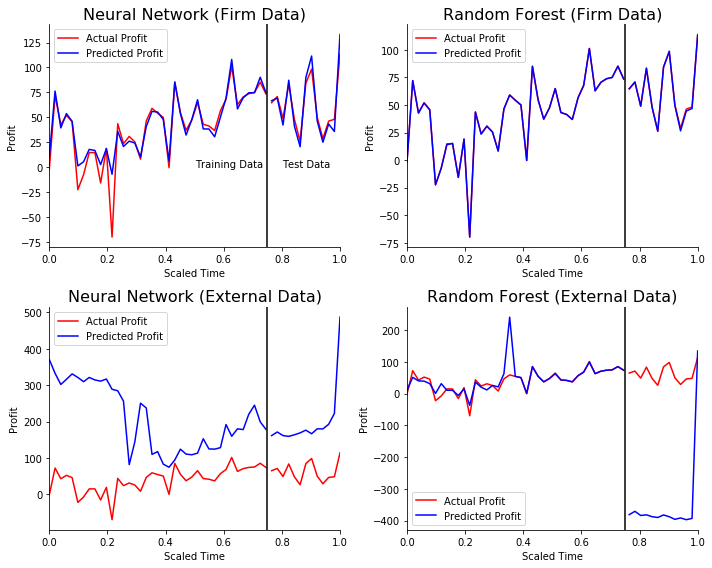

In [63]:
# Pick a random firm to show each time this is run
gvkeys = len(comp_train['GVKEY'].unique())
rand_key = np.random.randint(low=0, high=gvkeys)
gvkey = comp_train['GVKEY'].unique()[rand_key]
# Uncomment to get the same firm every time
# gvkey = 1230

colors = ['red', 'blue']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

comp_train[comp_train['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[0,0])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[0,0], label='_nolegend_')
comp_train[comp_train['GVKEY'] == gvkey].plot(y='firm_nn_predicted_niq', x='scaled_time', c=colors[1], ax=axes[0,0])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='firm_nn_predicted_niq', x='scaled_time', c=colors[1], ax=axes[0,0], label='_nolegend_')

comp_train[comp_train['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[0,1])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[0,1], label='_nolegend_')
comp_train[comp_train['GVKEY'] == gvkey].plot(y='firm_rf_predicted_niq', x='scaled_time', c=colors[1], ax=axes[0,1])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='firm_rf_predicted_niq', x='scaled_time', c=colors[1], ax=axes[0,1], label='_nolegend_')

comp_train[comp_train['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[1,0])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[1,0], label='_nolegend_')
comp_train[comp_train['GVKEY'] == gvkey].plot(y='ext_nn_predicted_niq', x='scaled_time', c=colors[1], ax=axes[1,0])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='ext_nn_predicted_niq', x='scaled_time', c=colors[1], ax=axes[1,0], label='_nolegend_')

comp_train[comp_train['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[1,1])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='niq', x='scaled_time', c=colors[0], ax=axes[1,1], label='_nolegend_')
comp_train[comp_train['GVKEY'] == gvkey].plot(y='ext_rf_predicted_niq', x='scaled_time', c=colors[1], ax=axes[1,1])
comp_test[comp_test['GVKEY'] == gvkey].plot(y='ext_rf_predicted_niq', x='scaled_time', c=colors[1], ax=axes[1,1], label='_nolegend_')

for ax in axes.flat:
    ax.axvline(x=0.75, color='black')
    ax.set_xlabel('Scaled Time')
    ax.set_ylabel('Profit')
    ax.legend(['Actual Profit', 'Predicted Profit'])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axes[0,0].set_title('Neural Network (Firm Data)', size=16)
axes[0,1].set_title('Random Forest (Firm Data)', size=16)
axes[1,0].set_title('Neural Network (External Data)', size=16)
axes[1,1].set_title('Random Forest (External Data)', size=16)

axes[0,0].annotate('Training Data', xy=(0.5, 0))
axes[0,0].annotate('Test Data', xy=(0.8, 0))

fig.tight_layout()

Since this only shows data for one firm at a time, we can also plot the predicted and actual values for all of the firms at once to see how the models perform more generally.

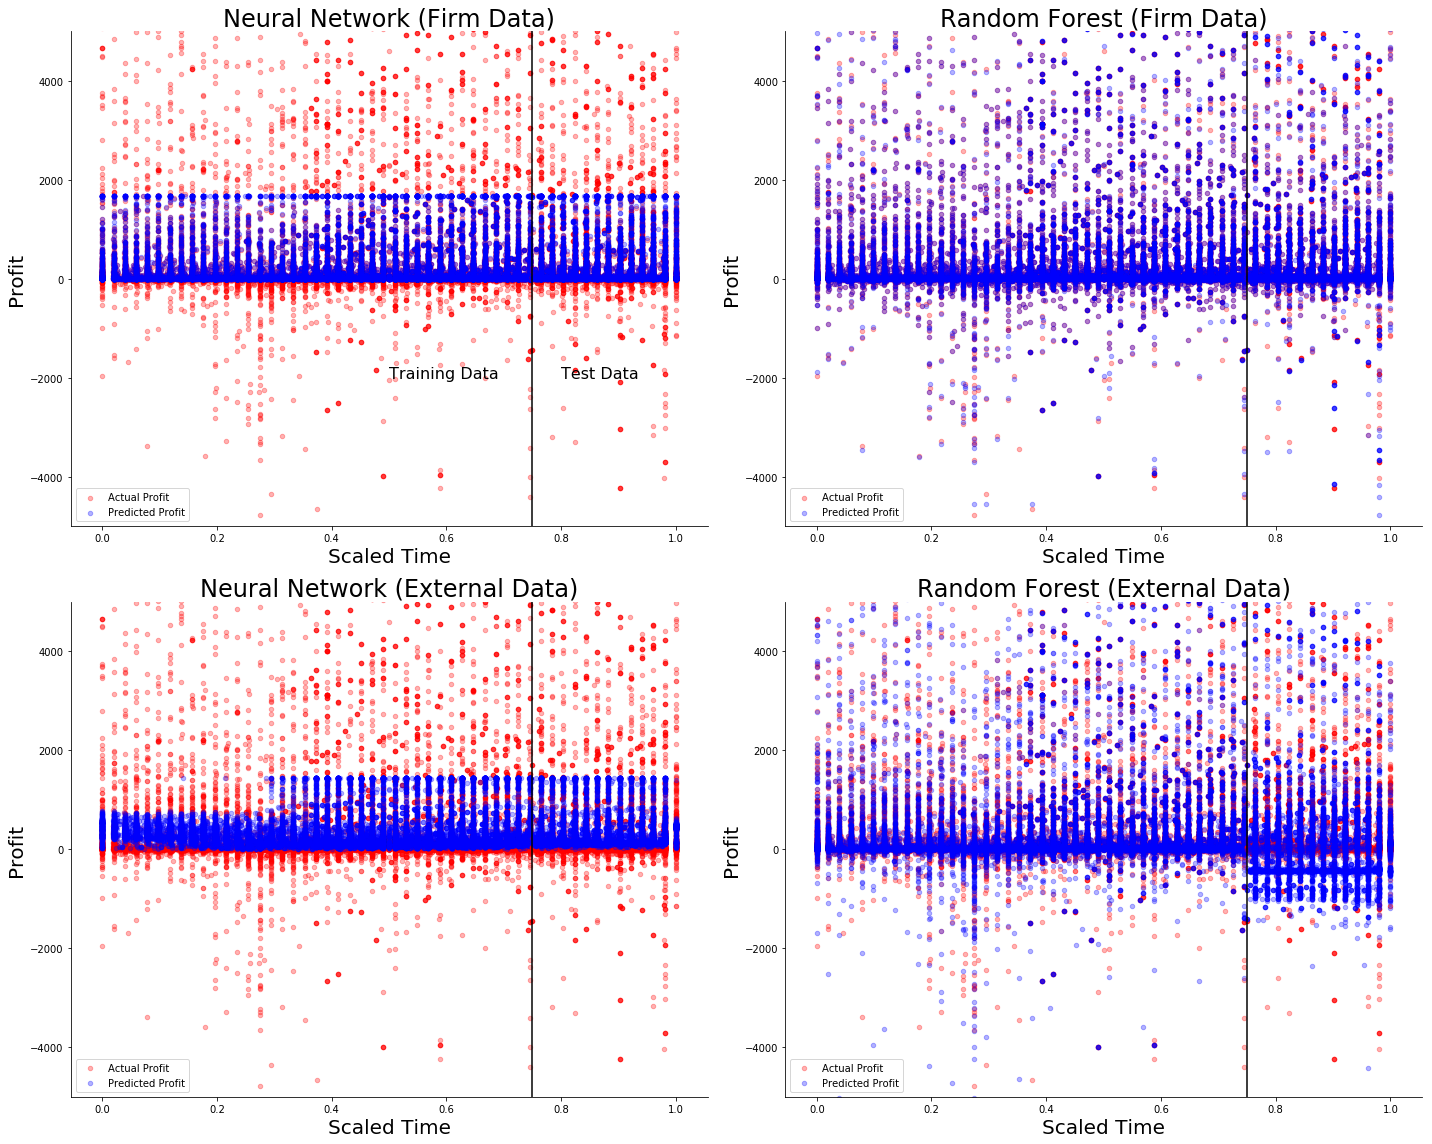

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(20,16))

comp_train.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[0,0])
comp_train.plot(y='firm_nn_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[0,0])
comp_test.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[0,0], label='_nolegend_')
comp_test.plot(y='firm_nn_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[0,0], label='_nolegend_')

comp_train.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[0,1])
comp_train.plot(y='firm_rf_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[0,1])
comp_test.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[0,1], label='_nolegend_')
comp_test.plot(y='firm_rf_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[0,1], label='_nolegend_')

comp_train.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[1,0])
comp_train.plot(y='ext_nn_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[1,0])
comp_test.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[1,0], label='_nolegend_')
comp_test.plot(y='ext_nn_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[1,0], label='_nolegend_')

comp_train.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[1,1])
comp_train.plot(y='ext_rf_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[1,1])
comp_test.plot(y='niq', x='scaled_time', kind='scatter', c=colors[0], alpha=0.3, ax = axes[1,1], label='_nolegend_')
comp_test.plot(y='ext_rf_predicted_niq', x='scaled_time', kind='scatter', c=colors[1], alpha=0.3, ax=axes[1,1], label='_nolegend_')

for ax in axes.flat:
    ax.set_ylim(-5000, 5000)
    ax.axvline(x=0.75, color='black', label='_nolegend_')
    ax.set_xlabel('Scaled Time', size=20)
    ax.set_ylabel('Profit', size=20)
    ax.legend(['Actual Profit', 'Predicted Profit'])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axes[0,0].set_title('Neural Network (Firm Data)', size=24)
axes[0,1].set_title('Random Forest (Firm Data)', size=24)
axes[1,0].set_title('Neural Network (External Data)', size=24)
axes[1,1].set_title('Random Forest (External Data)', size=24)
axes[0,0].annotate('Training Data', xy=(0.5, -2000), size=16)
axes[0,0].annotate('Test Data', xy=(0.8, -2000), size=16)

fig.tight_layout()

These plots actually show some striking differences between the models. It seems that the neural networks are not perfoming as well as we would like because they refuse to predict below some minimum bound or above some maximum bound. It seems that the neural networks minimize mse primarily by always predicting close to the mean, so it seems they haven't actually learned that much. I could try to improve this by making the grid search larger, but it already takes a very long time to run. 

The random forest on the other hand seems to perform quite well, especially for the firm data where even after over the test data. However, on the external data the random forest may be over-fit as when the test data starts the performance seems much worse.

In order to get a better idea of how each model performs overall, we should look at the actual metrics. Of particular concern is the MSE over the test data so the table is sorted in decending order of this metric, but all of the metrics are shown.

In [17]:
results = pd.concat([pd.DataFrame(optimal_firm_nn).transpose(), 
                     pd.DataFrame(firm_rf).iloc[0,:].to_frame().transpose(),
                     pd.DataFrame(optimal_ext_nn).transpose(), 
                     pd.DataFrame(ext_rf).iloc[0,:].to_frame().transpose()
                    ], 
                    axis=0)

results['Name'] = ['Firm variables neural net',
                   'Firm variables random forest', 
                   'External variables neural net',
                   'External variables random forest']

results = results[['Name', 'mse_train', 'mse_cv', 'mse_test']].set_index('Name')
results.columns = ['Training MSE', 'Cross Validation MSE', 'Test MSE']
results = results.sort_values(by='Test MSE', ascending=True)
pd.options.display.float_format = '{:.2f}'.format
print(results) 

                                 Training MSE Cross Validation MSE   Test MSE
Name                                                                         
Firm variables random forest        106300.27           2477636.70  122300.83
Firm variables neural net          2049507.03           2202532.30 1869173.91
External variables neural net      2442509.67           2557930.82 2277054.28
External variables random forest    272093.78           7069251.95 2511267.68


## Conclusions
The results of this test are actually quite interesting. The "best" model according to the prediction over the test period is the firm variables random forest. Indeed, this model performs better than the others by far in all metrics. This is perhaps unsurprising, because with all firm variables availible, the model simply needs to realize that GVKEY uniquely identifies a company, and that for each period the profit is just the revenue minus the expenses, both of which are known.
The random forest might have an easier time picking up this pattern because it is simpler than the neural network. However, in practice this model is not particularly useful, because if revenue and expenses are known, then obviously profit is also known too. 

Perhaps more interesting is that external variables inputs the neural network actually performs somewhat better than the random forest on the test data, despite performing much worse on the training data. This seems to confirm the intution that the random forest is over-fit. It seems likely that since there is less information here and this is a substantially harder problem, the flexibility of the neural network to learn complex relationships gives it the edge over the random forest, whereas with the firm data where the problem was actually quite simple, the complexity of the neural network actually made it perform worse because it was difficult to train. 

If we can trust this external variables neural network then that is quite useful, because we could use it to predict how we think firms will perform on their quarterly financial reports which if accurate enough would allow for arbitraging on the stock market. The best ways to improve this model would be to add more external data, for example, consumer confidence index, competition idex, etc, and to expand the size of the grid search to include a larger range of potential network shapes. The more information is availible the more accurate the predictions could be.